In [1]:
############## Loading drive for Colab to have access ##############
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/Shared drives/Colab Work/TrainingData'

/content/drive/Shared drives/Colab Work/TrainingData


In [3]:
############## Importing all required libraries ##############
import pandas as pd
import numpy as np
import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from scipy.stats import mode

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
############## Getting a list of all the sessions ##############
dirname = '.'

X_data_files = []
Y_label_files = []
X_time_files = []
Y_time_files = []

for files in os.listdir(dirname):
    if files.endswith('__x.csv'):
      X_data_files.append(files)
    elif files.endswith('__y.csv'):
      Y_label_files.append(files)
    elif files.endswith('__x_time.csv'):
      X_time_files.append(files)
    elif files.endswith('__y_time.csv'):
      Y_time_files.append(files)

X_data_files.sort()
Y_label_files.sort()
X_time_files.sort()
Y_time_files.sort()

assert len(X_data_files) == len(X_time_files), "X features files dont match with time files"
assert len(Y_label_files) == len(Y_time_files), "Y label files dont match with time files"

print("Number of sessions:",len(X_data_files))

Number of sessions: 29


# Data Pre-processing

In [6]:
############## Merging spatial data with label data by using Upsampling ##############
data_df = pd.DataFrame()
subject_list_x = [name.removesuffix('__x_time.csv') for name in X_time_files]
subject_list_y = [name.removesuffix('__y_time.csv') for name in Y_time_files]

for idx, (sub_id_x, sub_id_y) in enumerate(zip(subject_list_x, subject_list_y)):

    # Check that data from session being merged
    if sub_id_x != sub_id_y:
      print('Error: Different sessions being merged')
      print('X_session:', sub_id_x)
      print('Y_session:', sub_id_y)
      break

    # Reading X data and time
    X_data = pd.read_csv('{id}__x.csv'.format(id=sub_id_x), names=['x_acc','y_acc','z_acc','x_gyro','y_gyro','z_gyro'], header=None)
    X_time = pd.read_csv('{id}__x_time.csv'.format(id=sub_id_x), names=['time'], header=None)
    assert X_data.shape[0] == X_time.shape[0], "X data does not match with X time"

    # Normalize meauserments
    X_data = X_data.apply(lambda iterator: ((iterator - iterator.mean())/(iterator.std())).round(2))
    
    # Concatenating time with x features
    X = pd.concat([X_data, X_time], axis=1)
    X['session'] = sub_id_x
    X['time'] = X['time'].apply(lambda x: datetime.datetime.fromtimestamp(x))
    X = X.set_index('time')

    # Reading Y labels and time
    Y_data = pd.read_csv('{id}__y.csv'.format(id=sub_id_y),names=['label'],header=None)
    Y_time = pd.read_csv('{id}__y_time.csv'.format(id=sub_id_y),names=['time'],header=None)
    assert Y_data.shape[0] == Y_time.shape[0], "Y labels do not match with Y time"

    # Concatenating time with y labels
    Y_time = Y_time + 0.005
    Y = pd.concat([Y_data, Y_time],axis=1)
    Y['time'] = Y['time'].apply(lambda x: datetime.datetime.fromtimestamp(x))
    Y = Y.set_index('time')

    # Merging X and Y based on nearest neighbor w.r.t. time
    Y = Y.resample('25L').asfreq()
    Y['label']= Y['label'].fillna(Y['label'].rolling(window=12, min_periods=1, center=True).apply(lambda x: x.mode()[0]))
    merged_df = X.join(Y, how='inner')

    # Join all rows of the different sessions
    data_df = pd.concat([data_df, merged_df], axis=0)

data_df['label'] = data_df['label'].astype('int')
print("\nTotal number of session ids: ", data_df['session'].nunique())
print("List of unique labels: ", data_df.label.unique(), "\n")
display(data_df[3410:3420])



Total number of session ids:  29
List of unique labels:  [0 1 2 3] 



,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro,session,label
time,,,,,,,,
1970-01-01 00:01:25.275,0.01,-0.40,-0.10,-0.59,-0.18,0.92,subject_001_01,1
1970-01-01 00:01:25.300,0.25,-0.02,-0.43,-0.69,-0.26,0.96,subject_001_01,1
1970-01-01 00:01:25.325,0.31,0.17,-0.41,-0.88,-0.56,1.04,subject_001_01,1
1970-01-01 00:01:25.350,0.36,0.05,-0.31,-1.04,-0.69,0.95,subject_001_01,1
1970-01-01 00:01:25.375,0.44,1.29,0.85,-1.31,-0.96,0.85,subject_001_01,1
1970-01-01 00:01:25.400,0.08,1.78,1.12,-1.37,-1.33,0.83,subject_001_01,0
1970-01-01 00:01:25.425,-0.67,1.58,1.45,-1.05,-1.46,1.28,subject_001_01,0
1970-01-01 00:01:25.450,-1.28,0.64,1.64,-0.45,-1.32,1.58,subject_001_01,0
1970-01-01 00:01:25.475,-1.21,-1.43,2.20,0.13,0.04,2.22,subject_001_01,0


In [7]:
############## Verify correct mapping of spatial data to label data ##############
sub_id_x = 'subject_001_01'
X_data = pd.read_csv('{id}__x.csv'.format(id=sub_id_x), names=['x_acc','y_acc','z_acc','x_gyro','y_gyro','z_gyro'], header=None)
X_time = pd.read_csv('{id}__x_time.csv'.format(id=sub_id_x), names=['time'], header=None)
X = pd.concat([X_data, X_time], axis=1)
X['time'] = X['time'].apply(lambda x: datetime.datetime.fromtimestamp(x))
display(X[3411:3421])

,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro,time
3411,1.200694,4.882500,5.689861,-1.906456,-0.276644,0.631750,1970-01-01 00:01:25.275
3412,2.852627,7.634553,3.808437,-2.250398,-0.423067,0.662694,1970-01-01 00:01:25.300
3413,3.248788,8.983196,3.931955,-2.883767,-0.936103,0.719250,1970-01-01 00:01:25.325
3414,3.572963,8.157229,4.497856,-3.391945,-1.180111,0.654033,1970-01-01 00:01:25.350
3415,4.109491,17.196160,11.086030,-4.253921,-1.650755,0.586575,1970-01-01 00:01:25.375
3416,1.719249,20.793280,12.626550,-4.464584,-2.291167,0.567575,1970-01-01 00:01:25.400
3417,-3.279081,19.315260,14.494720,-3.426666,-2.523541,0.887570,1970-01-01 00:01:25.425
3418,-7.341888,12.483630,15.544230,-1.478647,-2.269522,1.104205,1970-01-01 00:01:25.450
3419,-6.913432,-2.644415,18.751660,0.411298,0.106645,1.556774,1970-01-01 00:01:25.475
3420,-1.064240,-0.978857,8.892290,1.419677,1.908619,1.500667,1970-01-01 00:01:25.500


In [8]:
############## Verify correct NA fill using rolling window ##############
sub_id_x = 'subject_001_01'
Y_data = pd.read_csv('{id}__y.csv'.format(id=sub_id_x), names=['label'], header=None)
Y_time = pd.read_csv('{id}__y_time.csv'.format(id=sub_id_x), names=['time'], header=None)
Y = pd.concat([Y_data, Y_time], axis=1)
Y['time'] = Y['time'].apply(lambda x: datetime.datetime.fromtimestamp(x))
display(Y[848:860])

,label,time
848,1,1970-01-01 00:01:24.820
849,1,1970-01-01 00:01:24.920
850,1,1970-01-01 00:01:25.020
851,1,1970-01-01 00:01:25.120
852,1,1970-01-01 00:01:25.220
853,1,1970-01-01 00:01:25.320
854,0,1970-01-01 00:01:25.420
855,0,1970-01-01 00:01:25.520
856,0,1970-01-01 00:01:25.620
857,0,1970-01-01 00:01:25.720


# Data Preparation for Neural Network Input

In [9]:
############## Data Prep for Conv1D ##############
from scipy import stats
def data_prep(window_size,step_size,data_all,subject_name_instances):
    train_labels = []
    data=[]
    session = []
    for subject_name_instance in subject_name_instances:
        df_train = data_all[data_all['session']==subject_name_instance]
        for i in range(0, df_train.shape[0] - window_size, step_size):
            x_acc = df_train['x_acc'].values[i: i + window_size].reshape(1,window_size)
            y_acc = df_train['y_acc'].values[i: i + window_size].reshape(1,window_size)
            z_acc = df_train['z_acc'].values[i: i + window_size].reshape(1,window_size)
            x_gyro = df_train['x_gyro'].values[i: i + window_size].reshape(1,window_size)
            y_gyro = df_train['y_gyro'].values[i: i + window_size].reshape(1,window_size)
            z_gyro = df_train['z_gyro'].values[i: i + window_size].reshape(1,window_size)
            label = stats.mode(df_train['label'][i: i + window_size])[0][0]
            data_point=np.vstack((x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro))
            train_labels.append(label)
            data.append(data_point.reshape(1,6,window_size))
            session.append(subject_name_instance)
    return np.array(data), np.array(train_labels), np.array(session)

# Data Reshaping for conv1d layer input
data_reshape, label_reshape, session_reshape = data_prep(60,4,data_df,subject_list_x)

# Construct final dataset for training
data_df=pd.DataFrame(zip(data_reshape,label_reshape, session_reshape),columns=['data','label','session'])
print("Data Shape:", data_reshape.shape, "Label Shape", label_reshape.shape)

<ipython-input-9-56a73745e555>:16: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df_train['label'][i: i + window_size])[0][0]


Data Shape: (334978, 1, 6, 60) Label Shape (334978,)


# Analysing Data Imbalance

label
0    251292
1     13811
2     18266
3     51609
dtype: int64


<Axes: xlabel='label', ylabel='count'>

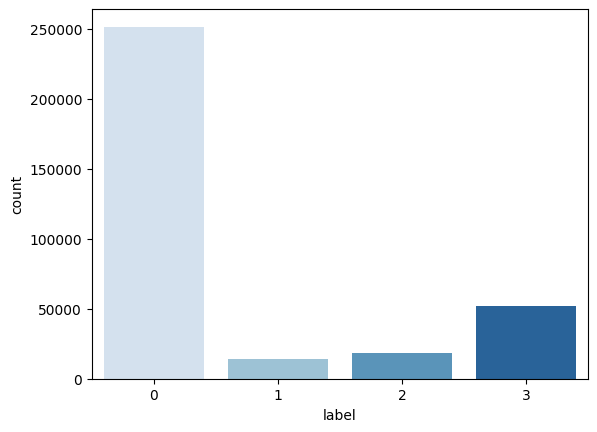

In [10]:
############## Interpretting data imbalance in pre-processed dataset ##############
data_df['label'] = data_df['label'].astype(int)
print(data_df.groupby('label').size())

sns.countplot(x ='label', data = data_df, palette="Blues")

In [11]:
############## Split Data into training and testing ##############

# Splitting the data by using session leave out
session_leave_out = ['subject_006_01','subject_006_02','subject_006_03']

val_array = data_df.session.isin(session_leave_out)
train_data = data_df[np.invert(val_array)]
val_data = data_df[val_array]
X_train, y_train = train_data[['data']], train_data[['label']]
X_val, y_val = val_data[['data']], val_data[['label']]

print("Train set size:",train_data.shape[0], "Val set size:",val_data.shape[0])
print("Val split %: ", round(val_data.shape[0]/data_df.shape[0]*100,2))

Train set size: 296819 Val set size: 38159
Val split %:  11.39


label
0    221054
1     12348
2     16558
3     46859
dtype: int64
label
0    74.474343
1     4.160111
2     5.578484
3    15.787062
dtype: float64
Train Set Size: 296819


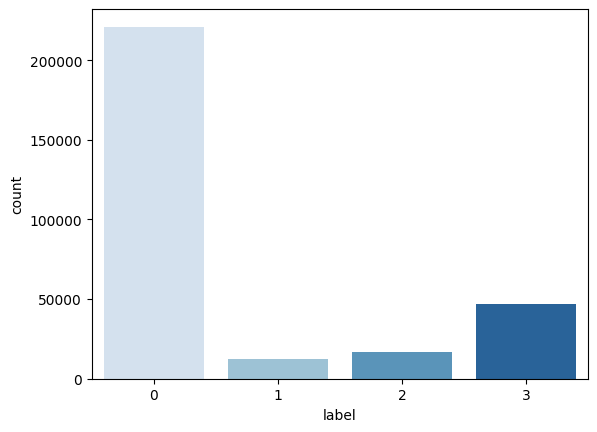

In [12]:
############## Checking train set distribution ##############
print(train_data.groupby('label').size())
print(train_data.groupby('label').size()/train_data['label'].shape[0]*100)
sns.countplot(x ='label', data = train_data, palette="Blues")
print("Train Set Size:", train_data['label'].shape[0])

label
0    30238
1     1463
2     1708
3     4750
dtype: int64
label
0    79.242119
1     3.833958
2     4.476008
3    12.447915
dtype: float64
Test Set Size: 38159


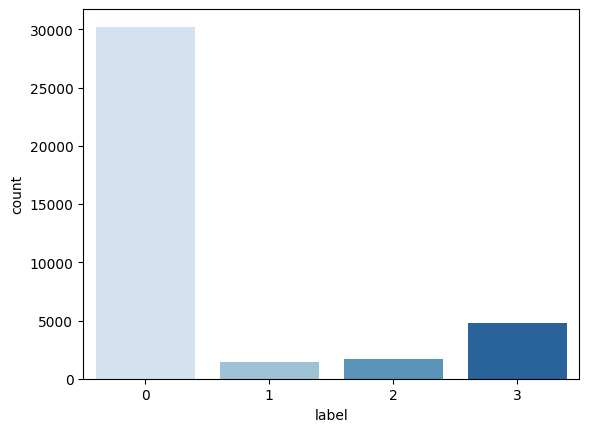

In [14]:
############## Checking validation set distribution ##############
print(val_data.groupby('label').size())
print(val_data.groupby('label').size()/val_data['label'].shape[0]*100)
sns.countplot(x ='label', data = val_data, palette="Blues")
print("Test Set Size:", val_data['label'].shape[0])

# Training the model

In [15]:
############## Calculating class weights to use with loss function ##############
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes=y_train.label.unique(), y=y_train.label)
class_weights = torch.Tensor(class_weights)
print("Class weights", class_weights)

Class weights tensor([0.3357, 6.0095, 4.4815, 1.5836])


In [16]:
# Training parameters
batch_size = 256
learning_rate = 0.001
num_epochs = 25

In [17]:
############## Defining CNN model architecture ##############
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(6, 12, 5,stride = 1)
        self.conv2 = nn.Conv1d(12, 24, 5,stride = 1)
        self.conv3 = nn.Conv1d(24, 48, 5,stride = 1)
        self.fc1 = nn.Linear(48*48, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        x = x.float() 
        x = self.conv1(x)                                     
        x = F.relu(x)
        x = self.conv2(x)                                      
        x = F.relu(x)
        x = self.conv3(x)                                     
        x = F.relu(x)  
        x = x.view(-1, 48*48)                       
        x = self.fc1(x)                                       
        x = F.relu(x)
        x = self.fc2(x)                                       
        x = F.relu(x)
        x = self.fc3(x)                                       
        return x

In [18]:
############## Defining CNN LSTM model architecture ##############
class CNN_LSTM_Batch_Normalization(nn.Module):
  def __init__(self):
    
    super(CNN_LSTM_Batch_Normalization, self).__init__()
    
    self.conv1 = nn.Conv1d(6, 12, 5,stride = 1,padding = 2)
    self.norm1 = nn.BatchNorm1d(12)
    self.conv2 = nn.Conv1d(12, 24, 5,stride = 1,padding = 2)
    self.norm2 = nn.BatchNorm1d(24)
    self.conv3 = nn.Conv1d(24, 48, 5,stride = 1,padding = 2)
    self.norm3 = nn.BatchNorm1d(48)
    self.lstm = nn.LSTM(48,128,2, batch_first=True)
    self.fc1 = nn.Linear(60*128, 256)
    self.norm4 = nn.BatchNorm1d(256)
    self.fc2 = nn.Linear(256, 64)
    self.norm5 = nn.BatchNorm1d(64)
    self.fc3 = nn.Linear(64, 4)
  
  def forward(self, x):
    h0 = torch.zeros(2, x.size(0), 128).to(device)
    c0 = torch.zeros(2, x.size(0), 128).to(device)

    x = x.float() 
    x = self.conv1(x)                                     
    x = self.norm1(x) 
    x = F.relu(x)
    
    x = self.conv2(x)                                      
    x = self.norm2(x) 
    x = F.relu(x)

    x = self.conv3(x)                                     
    x = self.norm3(x)
    x = F.relu(x)

    x = x.reshape(-1,60,48)
    x, state = self.lstm(x, (h0,c0))
    x = x.reshape(x.shape[0],-1) 

    x = self.fc1(x) 
    x = self.norm4(x)
    x = F.relu(x)
      
    x = self.fc2(x)                                       
    x = self.norm5(x)   
    x = F.relu(x)
    
    x = self.fc3(x)                                       
      
    return x

In [28]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=False, path="best_model.pth", trace_func=print):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            
        elif score < self.best_score:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [25]:
############## Defining dataset class for loading data for model use ##############
class dataset(torch.utils.data.Dataset):
    def __init__(self,data,label):
        self.data = data
        self.label = label
                
    def __len__(self):
        self.filelength = len(self.data)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        data_idx = self.data[idx][0]
        data_info = data_idx.reshape(6, 60)
        label_idx = self.label[idx]
        label_info = torch.as_tensor(label_idx, dtype=torch.int64)
        label_info = torch.squeeze(label_info)
        return data_info, label_info

In [20]:
############## Loading data for model use ##############
train_dataset = dataset(X_train.to_numpy(), y_train.to_numpy())
val_dataset = dataset(X_val.to_numpy(), y_val.to_numpy())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, num_workers=0)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size=batch_size, num_workers=0)

print("Data loader data point size", train_dataset.__getitem__(0)[0].shape)
print("Data point size", X_train.to_numpy()[0][0].shape)

Data loader data point size (6, 60)
Data point size (1, 6, 60)


In [21]:
############## Initializing CNN model, loss function and optimizer #############
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
summary(model,(6,60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 12, 56]             372
            Conv1d-2               [-1, 24, 52]           1,464
            Conv1d-3               [-1, 48, 48]           5,808
            Linear-4                  [-1, 256]         590,080
            Linear-5                   [-1, 64]          16,448
            Linear-6                    [-1, 4]             260
Total params: 614,432
Trainable params: 614,432
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.34
Estimated Total Size (MB): 2.38
----------------------------------------------------------------


In [44]:
############## Initializing CNN + LSTM model, loss function and optimizer #############
model = CNN_LSTM_Batch_Normalization().to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [45]:
############## Function for model training ##############
def training(train_loader, val_loader, loss_fn, optimizer, num_epochs=10, verbose=True):
  train_loss_epoch = []
  val_loss_epoch = []

  save_directory = os.path.join('/content/drive/Shared drives/Colab Work','Model_Checkpoint')
  if not os.path.exists(save_directory):
      os.makedirs(save_directory)

  model_path = os.path.join(save_directory,"LSTM_CNN"+"_best_model.pth")
  early_stopping = EarlyStopping(patience=5, verbose=True, path=model_path)

  scheduler = ReduceLROnPlateau(optimizer, 'min', patience=1, verbose=True)

  for t in range(num_epochs):
    epoch_loss = 0
    acc_train = 0
    model.train()
    for data_train, label_train in train_loader:
        data_train = data_train.to(device)
        label_train = label_train.to(device)
        pred_train = model(data_train)
        loss_train = loss_fn(pred_train, label_train)

        _, pred_train = torch.max(pred_train,axis=1)
        acc_train += accuracy_score(pred_train.detach().cpu().numpy(), label_train.detach().cpu().numpy())
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        epoch_loss += loss_train.detach()/len(train_loader)

    acc_val, f1_val = 0, 0
    preds=[]
    model.eval()
    with torch.no_grad():
        epoch_loss_val = 0
        for data_val, label_val in val_loader:
            data_val = data_val.to(device)
            label_val = label_val.to(device)
            pred_val = model(data_val)
            loss_val = loss_fn(pred_val, label_val)

            _, pred_val = torch.max(pred_val,axis=1)
            preds.extend(pred_val.tolist()) 
            acc_val += accuracy_score(pred_val.detach().cpu().numpy(), label_val.detach().cpu().numpy())
            f1_val += f1_score(pred_val.detach().cpu().numpy(), label_val.detach().cpu().numpy(), average='macro')

            epoch_loss_val += loss_val.detach()/len(val_loader)
      
        scheduler.step(loss_val)

        if (t+1)%5==0 and verbose:    
          print("[Epoch {t:5d} of {epochs}] loss: {loss:1.6f} val_loss: {val_loss:1.6f}".format(t=t+1,epochs= num_epochs,loss=epoch_loss,val_loss=epoch_loss_val))
          print("Train Accuracy:",acc_train/len(train_loader),"Val Accuracy:",acc_val/len(val_loader))

        train_loss_epoch.append(epoch_loss.item())
        val_loss_epoch.append(epoch_loss_val.item())

        early_stopping(epoch_loss_val, model)
          
        if early_stopping.early_stop:
            print("Early stopping")
            print("[Epoch {t:5d} of {epochs}] loss: {loss:1.6f} val_loss: {val_loss:1.6f}".format(t=t+1,epochs= num_epochs,loss=epoch_loss,val_loss=epoch_loss_val))
            print("Train Accuracy:",acc_train/len(train_loader),"Val Accuracy:",acc_val/len(val_loader))
            break
    
  return acc_train/len(train_loader), acc_val/len(val_loader), f1_val/len(val_loader), train_loss_epoch, val_loss_epoch

acc_train, acc_val, f1_val, train_loss_epoch, val_loss_epoch = training(train_loader, val_loader, loss_fn, optimizer, num_epochs)

Validation loss decreased (inf --> 0.371135).  Saving model ...
EarlyStopping counter: 1 out of 5
Epoch 00003: reducing learning rate of group 0 to 1.0000e-04.
EarlyStopping counter: 2 out of 5
Validation loss decreased (0.371135 --> 0.226764).  Saving model ...
Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.
[Epoch     5 of 25] loss: 0.358336 val_loss: 0.208942
Train Accuracy: 0.8772793290854572 Val Accuracy: 0.9317447916666667
Validation loss decreased (0.226764 --> 0.208942).  Saving model ...
Validation loss decreased (0.208942 --> 0.198763).  Saving model ...
Epoch 00007: reducing learning rate of group 0 to 1.0000e-06.
EarlyStopping counter: 1 out of 5
EarlyStopping counter: 2 out of 5
Epoch 00009: reducing learning rate of group 0 to 1.0000e-07.
EarlyStopping counter: 3 out of 5
[Epoch    10 of 25] loss: 0.334617 val_loss: 0.203573
Train Accuracy: 0.8867071249531483 Val Accuracy: 0.9366927083333333
EarlyStopping counter: 4 out of 5
Epoch 00011: reducing learning ra

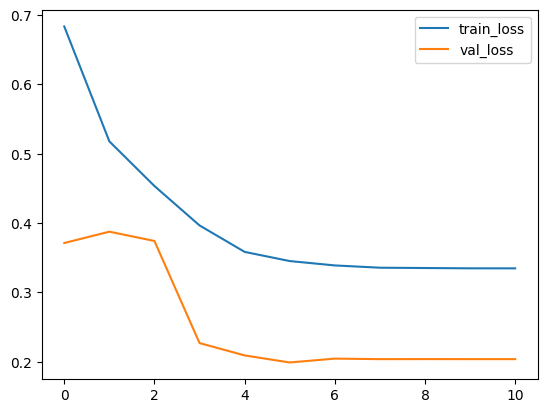

In [46]:
############## Plotting training and validation loss ##############
plt.plot(train_loss_epoch, label='train_loss')
plt.plot(val_loss_epoch,label='val_loss')
plt.legend()
plt.show()

In [47]:
############## Evaluating metrics for model predcition ##############
accuracy = 0
f1score = 0
prediction = []
target_v = []
confusion = [[0 for i in range(4)] for j in range(4)]
model.eval()
with torch.no_grad():
    epoch_loss_val = 0
    for data_val, label_val in val_loader:
        data_val = data_val.to(device)
        label_val = label_val.to(device)
        pred_val = model(data_val)
        _, pred_val = torch.max(pred_val,axis=1)

        for t, p in zip(pred_val.view(-1), label_val.view(-1)):
          confusion[p.long()][t.long()] += 1
          prediction.append(int(t))
          target_v.append(int(p))

print(classification_report(target_v, prediction, target_names=['Standing/Walking','Up_Stairs','Down_Stairs', 'Walking on grass']))


                  precision    recall  f1-score   support

Standing/Walking       0.96      0.97      0.96     30238
       Up_Stairs       0.66      0.99      0.79      1463
     Down_Stairs       0.92      0.98      0.95      1708
Walking on grass       0.95      0.67      0.79      4750

        accuracy                           0.94     38159
       macro avg       0.87      0.91      0.87     38159
    weighted avg       0.94      0.94      0.93     38159



array([[29397,     9,    18,  1339],
       [  529,  1453,     7,   209],
       [  147,     0,  1678,     0],
       [  165,     1,     5,  3202]])

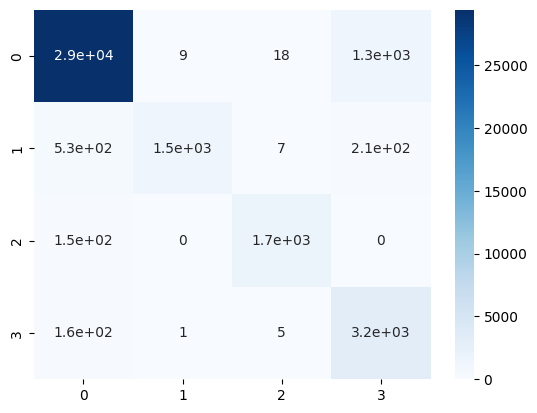

In [48]:
############## Plotting heatmap for prediction confusion matrix ##############
sns.heatmap(confusion_matrix(prediction, target_v), annot=True, cmap="Blues")
confusion_matrix(prediction, target_v)

# Cross Validation

In [ ]:
# Using cross validation across several subjects to make improve robustness of model
cross_val_list = [['subject_001_01', 'subject_001_02', 'subject_001_03', 'subject_001_04', 'subject_001_05', 'subject_001_06','subject_001_07', 'subject_001_08']
                  ,['subject_002_01', 'subject_002_02', 'subject_002_03', 'subject_002_04', 'subject_002_05']
                  ,['subject_003_01', 'subject_003_02', 'subject_003_03']
                  ,['subject_004_01', 'subject_004_02']
                  ,['subject_005_01', 'subject_005_02', 'subject_005_03']
                  ,['subject_006_01', 'subject_006_02', 'subject_006_03']
                  ,['subject_007_01', 'subject_007_02', 'subject_007_03', 'subject_007_04']
                  ,['subject_008_01']]

train_accs, val_accs, val_f1s = [], [], []
for session_leave_out in cross_val_list:
  print("Validation Set ---->",session_leave_out)
  val_array = data_df.session.isin(session_leave_out)
  train_data = data_df[np.invert(val_array)]
  val_data = data_df[val_array]

  X_train, y_train = train_data[['data']], train_data[['label']]
  X_val, y_val = val_data[['data']], val_data[['label']]

  print("Train set size:",train_data.shape[0],"Val set size:",val_data.shape[0])
  print("Val split %: ", round(val_data.shape[0]/(train_data.shape[0]+val_data.shape[0])*100,2))

  train_dataset = dataset(X_train.to_numpy(), y_train.to_numpy())
  val_dataset = dataset(X_val.to_numpy(), y_val.to_numpy())

  train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=batch_size, num_workers=0)
  val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size=batch_size, num_workers=0)

  model = CNN_LSTM_Batch_Normalization().to(device)
  loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  acc_train, acc_val, f1_val,  _, _ = training(train_loader, val_loader, loss_fn, optimizer, num_epochs=10, verbose=False)

  train_accs.append(acc_train)
  val_accs.append(acc_val)
  val_f1s.append(f1_val)

print("Training Accuracy:",sum(train_accs)/len(cross_val_list), "Validation Accuracy:", sum(val_accs)/len(cross_val_list), "Validation F1:",sum(val_f1s)/len(cross_val_list))

# Performing Inference on Test Set

In [49]:
cd '../TestData'

/content/drive/Shareddrives/Colab Work/TestData


In [50]:
############## Getting a list of all test sessions ##############
dirname = '.'
X_test_data_files = []
X_test_time_files = []
Y_test_time_files = []

for files in os.listdir(dirname):
    if files.endswith('__x.csv'):
      X_test_data_files.append(files)
    elif files.endswith('__x_time.csv'):
      X_test_time_files.append(files)
    elif files.endswith('__y_time.csv'):
      Y_test_time_files.append(files)

X_test_data_files.sort()
X_test_time_files.sort()
Y_test_time_files.sort()

assert len(X_test_data_files) == len(X_test_time_files), "X features files dont match with time files"

print("Number of sessions:",len(X_test_time_files))

Number of sessions: 4


In [51]:
############## Test Data preparation funciton for model prediction ##############
def data_prep_test(window_size,step_size,data_df):
    data=[]
    for i in range(0, data_df.shape[0] - window_size, step_size):
        x_acc = data_df['x_acc'].values[i: i + window_size].reshape(1,window_size)
        y_acc = data_df['y_acc'].values[i: i + window_size].reshape(1,window_size)
        z_acc = data_df['z_acc'].values[i: i + window_size].reshape(1,window_size)
        x_gyro = data_df['x_gyro'].values[i: i + window_size].reshape(1,window_size)
        y_gyro = data_df['y_gyro'].values[i: i + window_size].reshape(1,window_size)
        z_gyro = data_df['z_gyro'].values[i: i + window_size].reshape(1,window_size)
        data_point=np.vstack((x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro))
        data.append(data_point.reshape(1,6,window_size))

    return np.array(data)

In [52]:
############## Data loader function for the test session data ##############
class dataset_test(torch.utils.data.Dataset):
    def __init__(self,data):
        self.data = data
                
    def __len__(self):
        self.filelength = len(self.data)
        return self.filelength

    def __getitem__(self,idx):
        data_idx = self.data[idx][0]
        data_info = data_idx.reshape(6, 60)
        return data_info

In [53]:
############## Performing inference on test session ##############
test_subject_list_x = [name.removesuffix('__x_time.csv') for name in X_test_time_files]
test_subject_list_y = [name.removesuffix('__y_time.csv') for name in Y_test_time_files]

for idx, (sub_id_x, sub_id_y) in enumerate(zip(test_subject_list_x, test_subject_list_y)):

    print("Test for session:",sub_id_x)
    # Check that data from session being merged
    if sub_id_x != sub_id_y:
      print('Error: Different sessions being merged')
      print('X_session:', sub_id_x)
      print('Y_session:', sub_id_y)
      break

    # Reading X data and time
    X_data = pd.read_csv('{id}__x.csv'.format(id=sub_id_x), names=['x_acc','y_acc','z_acc','x_gyro','y_gyro','z_gyro'], header=None)
    X_time = pd.read_csv('{id}__x_time.csv'.format(id=sub_id_x), names=['time'], header=None)
    assert X_data.shape[0] == X_time.shape[0], "X data does not match with X time"

    # Normalize meauserments
    X_data = X_data.apply(lambda iterator: ((iterator - iterator.mean())/(iterator.std())).round(2))
    
    # Concatenating time with x features
    X = pd.concat([X_data, X_time], axis=1)
    X['session'] = sub_id_x
    X['time'] = X['time'].apply(lambda x: datetime.datetime.fromtimestamp(x))
    X = X.set_index('time')

    # Reading Y time
    Y_time = pd.read_csv('{id}__y_time.csv'.format(id=sub_id_y),names=['time'],header=None)

    # Concatenating time with y labels
    Y_time = Y_time + 0.005
    Y = pd.concat([Y_time],axis=1)
    Y['time'] = Y['time'].apply(lambda x: datetime.datetime.fromtimestamp(x))
    Y = Y.set_index('time')
    
    # Upsampling label data to match spatial data frequency
    Y = Y.resample('25L').asfreq()
    merged_df = X.join(Y, how='inner')

    # Data Reshaping for conv1d layer input
    data_reshape = data_prep_test(60,4,merged_df)
    print(data_reshape.shape)

    # Creating test dataset and data loader
    test_dataset = dataset_test(data_reshape)
    test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=batch_size, num_workers=0)

    # Generating predicitons through model
    preds = []
    model.eval()
    with torch.no_grad():
      for data_test in test_loader:
        data_test = data_test.to(device)
        pred_test = model(data_test)
        _, pred_test = torch.max(pred_test,axis=1)
        preds.extend(pred_test.tolist()) 

    # Generating final predictions by repeating first 15 predicitions
    preds = [preds[0]]*15 + preds

    # Saving predictions to repective csv
    pd.DataFrame(preds).to_csv('/content/drive/Shared drives/Colab Work/'+sub_id_x+'__y.csv', index=False, header=False)

Test for session: subject_009_01
(9483, 1, 6, 60)
Test for session: subject_010_01
(12255, 1, 6, 60)
Test for session: subject_011_01
(12925, 1, 6, 60)
Test for session: subject_012_01
(11315, 1, 6, 60)
